In [1]:
%load_ext autoreload
%autoreload 2



In [2]:

import torch.backends.cudnn as cudnn
from models import *
from prune import *
import os,sys

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'

timestamp = int(time.time())

net = VGG('VGG19')
net_name = net.name

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

ckpt_dir = './checkpoint/%s'%net_name
if not os.path.exists(ckpt_dir): 
    os.makedirs(ckpt_dir)
checkpoint_path = '%s/ckpt.t7'%ckpt_dir

# if not already exists, train one
if not os.path.exists(checkpoint_path):
    ! python main.py --resume --lr=0.01 --model $net_name
    
net.module.load_state_dict(torch.load(checkpoint_path)['net'])
model = net.module


# model = prune_conv_layer(net.module, 0.2, criterion='bn')
# model = prune_conv_layer(model, 0.2, criterion='bn')
# model = prune_conv_layer(model, 0.2, criterion='bn')
# model.load_state_dict(torch.load(checkpoint_path)['net'])

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

sparsity = 0.5904	==> Finetuning ..
Files already downloaded and verified
Files already downloaded and verified


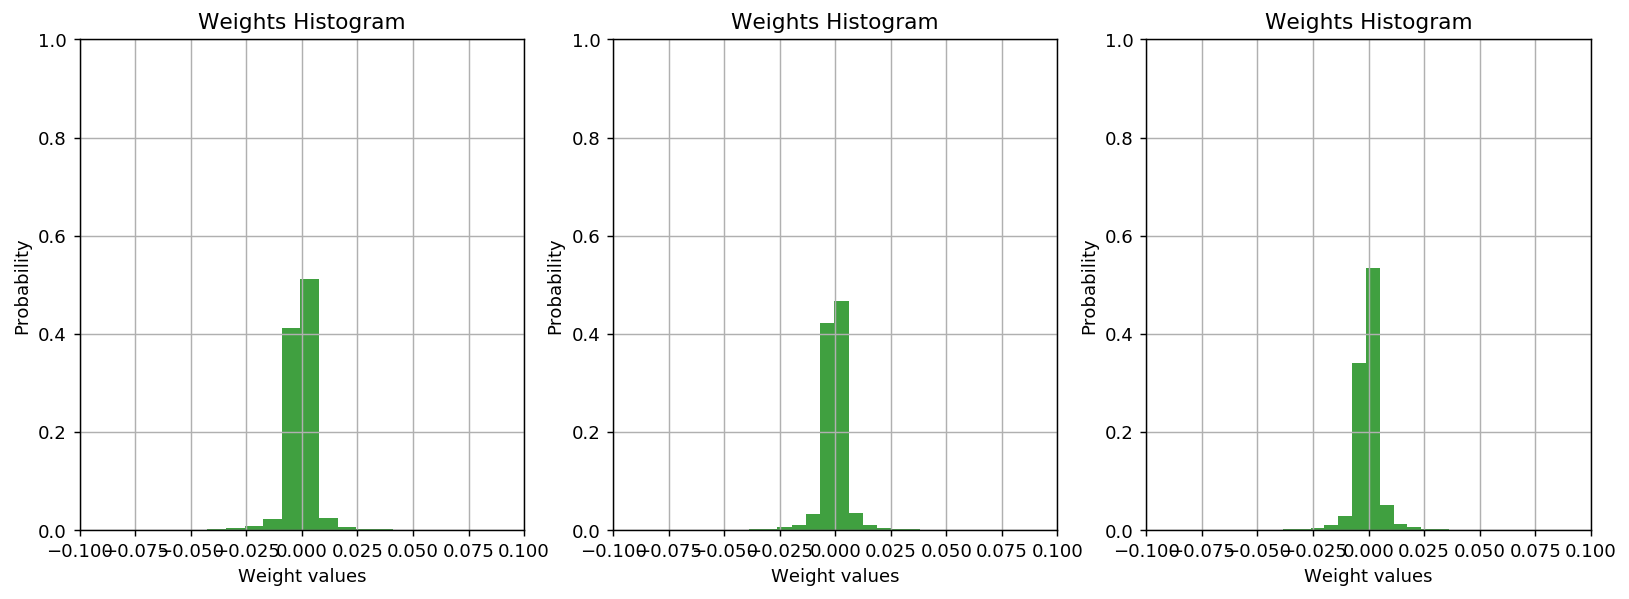

best accuracy = 88.83


In [3]:
# -----------------------------------------
# measures: inference time, model size, prediction accuracy


import pandas as pd
from IPython.display import display

timestamp = int(time.time())


# sparsity = np.linspace(0,1,10,endpoint=False)#[0.36]#->0.64 #
sparsity = [.5904]
ft_ep = 100
ft_leaningrate = 1e-2

df_res = pd.DataFrame(np.zeros((len(sparsity), ft_ep+3)), index=sparsity)
df_res.columns = list(df_res.columns)[:-3] + ['maxAcc', 'modSize', 'infTime']


for s in sorted(sparsity, reverse=True):
    print("sparsity = %g"%s, end="\t")
    _, df_res = prune_by_sparsity(model, s, ft_ep, ft_leaningrate, df_res, plot=True, ctri = 'random')
    print("best accuracy = %g"%df_res.at[s, 'maxAcc'])
    df_res.to_pickle("./checkpoint/vgg19/results/resDf_%d.pkl"%timestamp)
#     unpickled_df = pd.read_pickle("./results/resDf_%d.pkl"%timestamp)
#     display(df_res.loc[s,:])
    

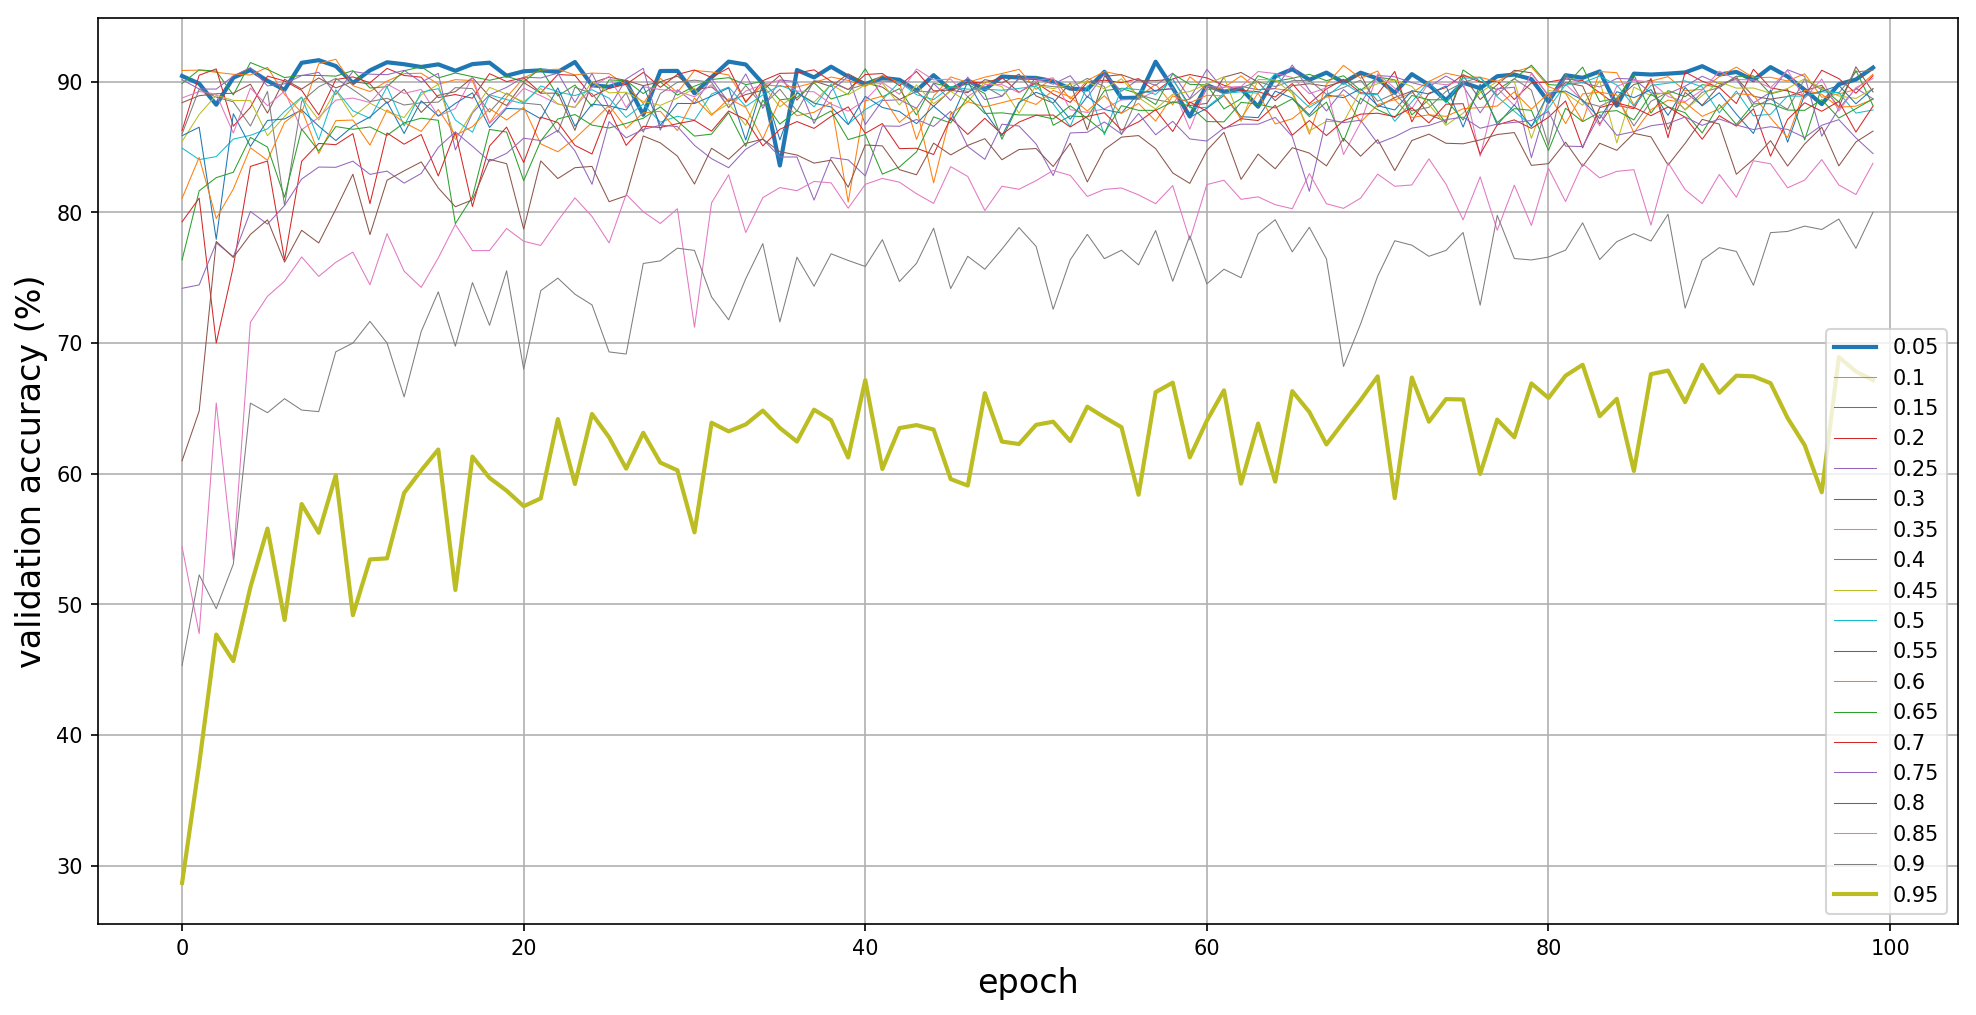

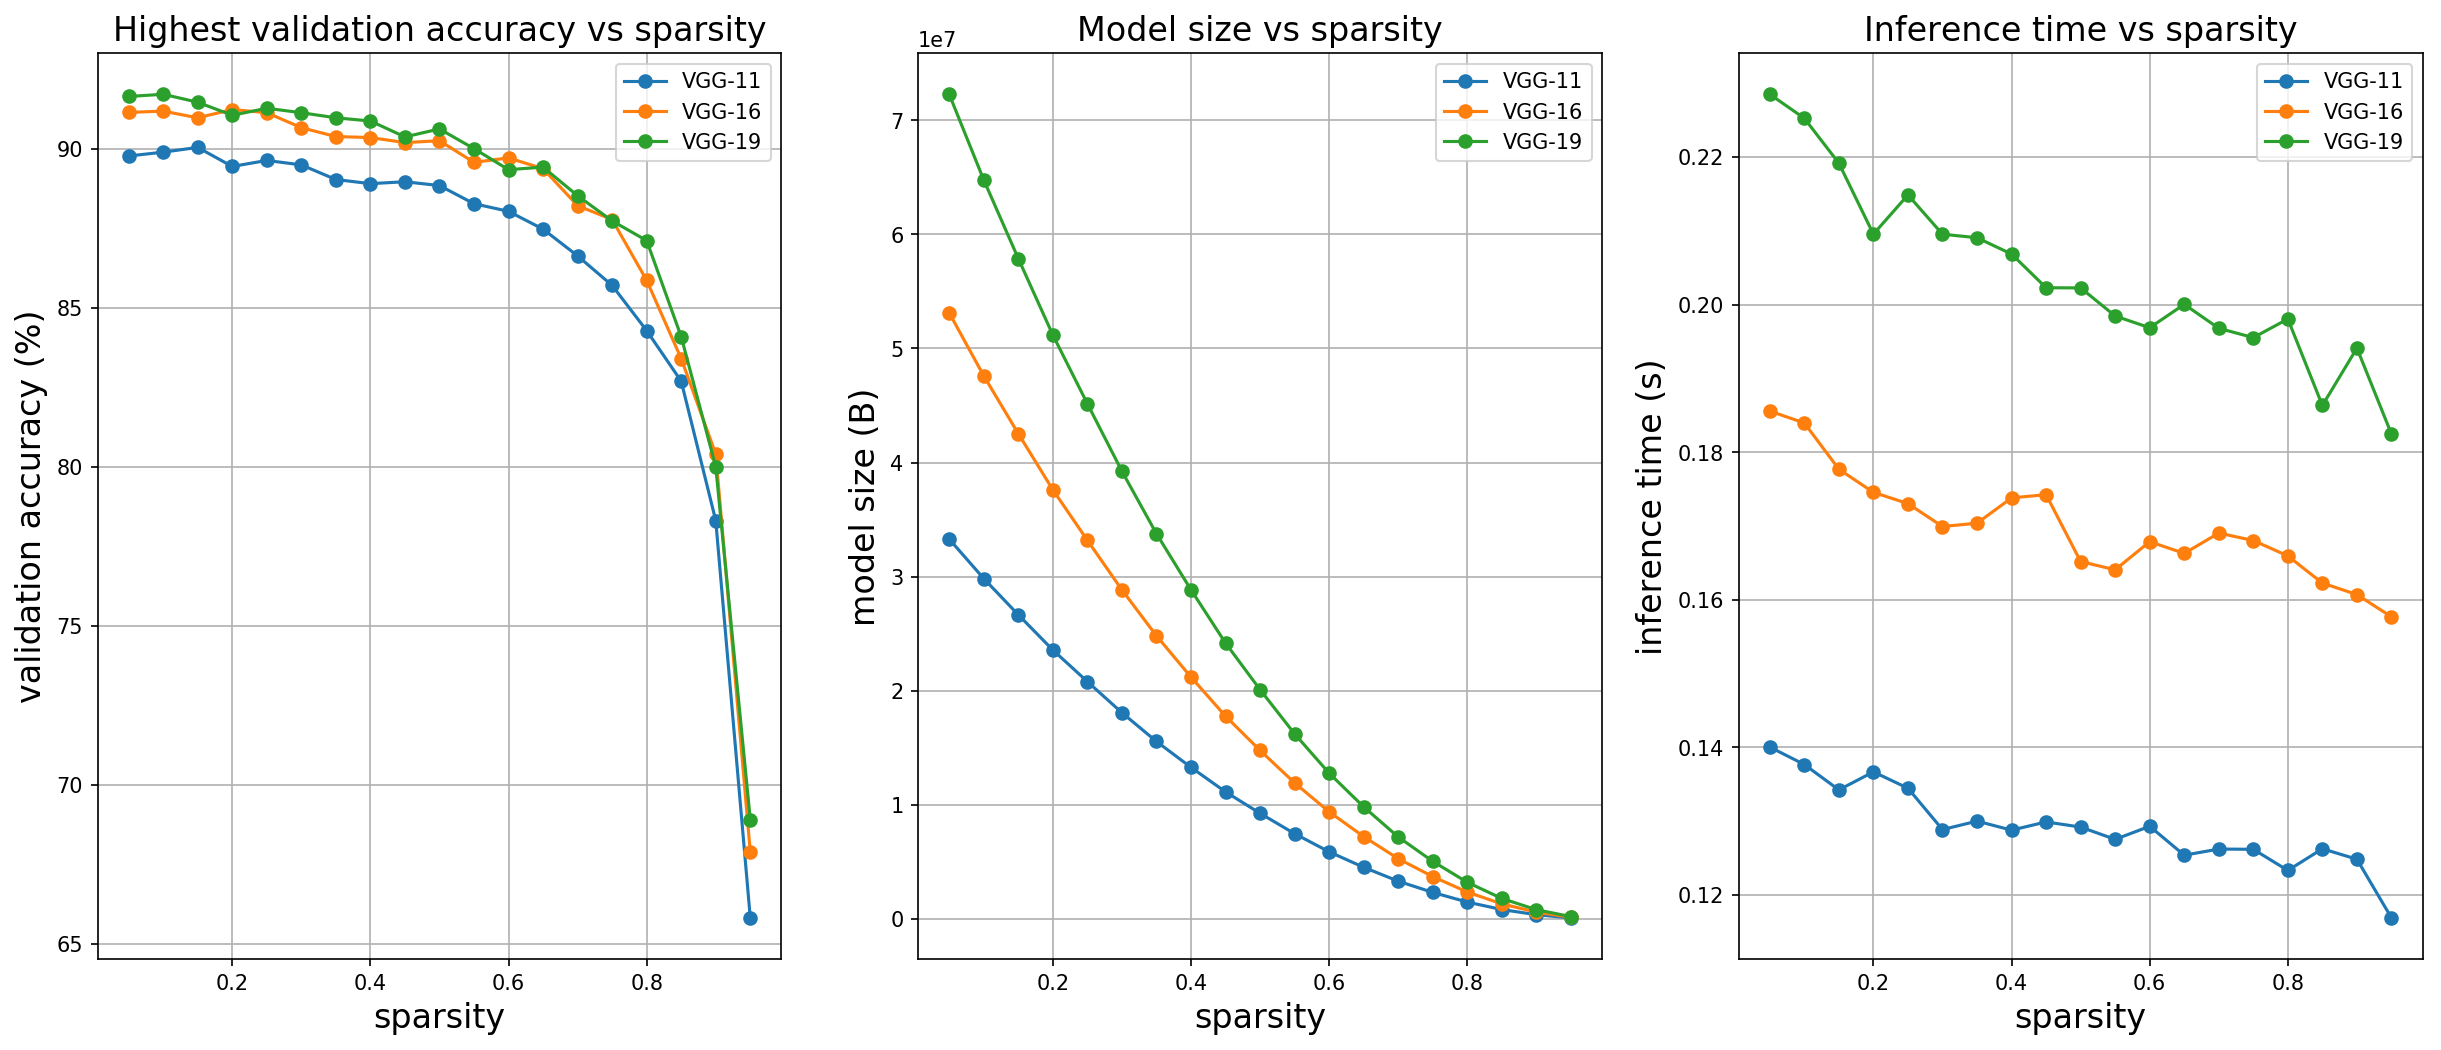

In [24]:
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt



df_res_11 = pd.read_pickle("./checkpoint/vgg11/results/resDf_1543896551.pkl")
df_res_16 = pd.read_pickle("./checkpoint/vgg16/results/resDf_1543896549.pkl")
df_res_19 = pd.read_pickle("./checkpoint/vgg19.bk/results/resDf_1543896547.pkl")


# df_res_19 = pd.read_pickle("./results/resDf_1540472413.pkl")

# finetune validation accuracy vs epoch
plt.figure(figsize = (16,8), dpi=150)
for index, row in df_res_16.iterrows():
    if index >= 0.95  or index >= 0.05 and index <= 0.06:
        lw=2
    else:
        lw=0.5
    plt.plot([i for i in range(len(row[:-3]))],row[:-3],lw=lw)
        
plt.grid(True)
# plt.title("Finetune validation accuracy vs epoch")
plt.xlabel("epoch", fontsize=16)
plt.ylabel("validation accuracy (%)", fontsize=16)
plt.legend([round(i,2) for i in df_res_19.index])
plt.show()

    
# finetune best validation accuracy vs sparsity    
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20,8), dpi=150)

p0 =  'maxAcc'
ax[0].plot(list(df_res_11.index), df_res_11[p0], '-o')
ax[0].plot(list(df_res_16.index), df_res_16[p0], '-o')
ax[0].plot(list(df_res_19.index), df_res_19[p0], '-o')


ax[0].set_title("Highest validation accuracy vs sparsity", fontsize=16)
ax[0].set_xlabel("sparsity", fontsize=16)
ax[0].set_ylabel("validation accuracy (%)", fontsize=16)
ax[0].grid(True)
ax[0].legend(['VGG-11','VGG-16','VGG-19'])


p1 = 'modSize'
ax[1].plot(list(df_res_11.index), df_res_11[p1], '-o')
ax[1].plot(list(df_res_16.index), df_res_16[p1], '-o')
ax[1].plot(list(df_res_19.index), df_res_19[p1], '-o')

ax[1].set_title("Model size vs sparsity", fontsize=16)
ax[1].set_xlabel("sparsity", fontsize=16)
ax[1].set_ylabel("model size (B)", fontsize=16)
ax[1].grid(True)
ax[1].legend(['VGG-11','VGG-16','VGG-19'])

p2 = 'infTime'
# ax[2].plot(df_res_11[p2])
ax[2].plot(list(df_res_11.index), df_res_11[p2], '-o')
ax[2].plot(list(df_res_16.index), df_res_16[p2], '-o')
ax[2].plot(list(df_res_19.index), df_res_19[p2], '-o')

ax[2].set_title("Inference time vs sparsity", fontsize=16)
ax[2].set_xlabel("sparsity", fontsize=16)
ax[2].set_ylabel("inference time (s)", fontsize=16)
ax[2].grid(True)
ax[2].legend(['VGG-11','VGG-16','VGG-19'])
plt.show()




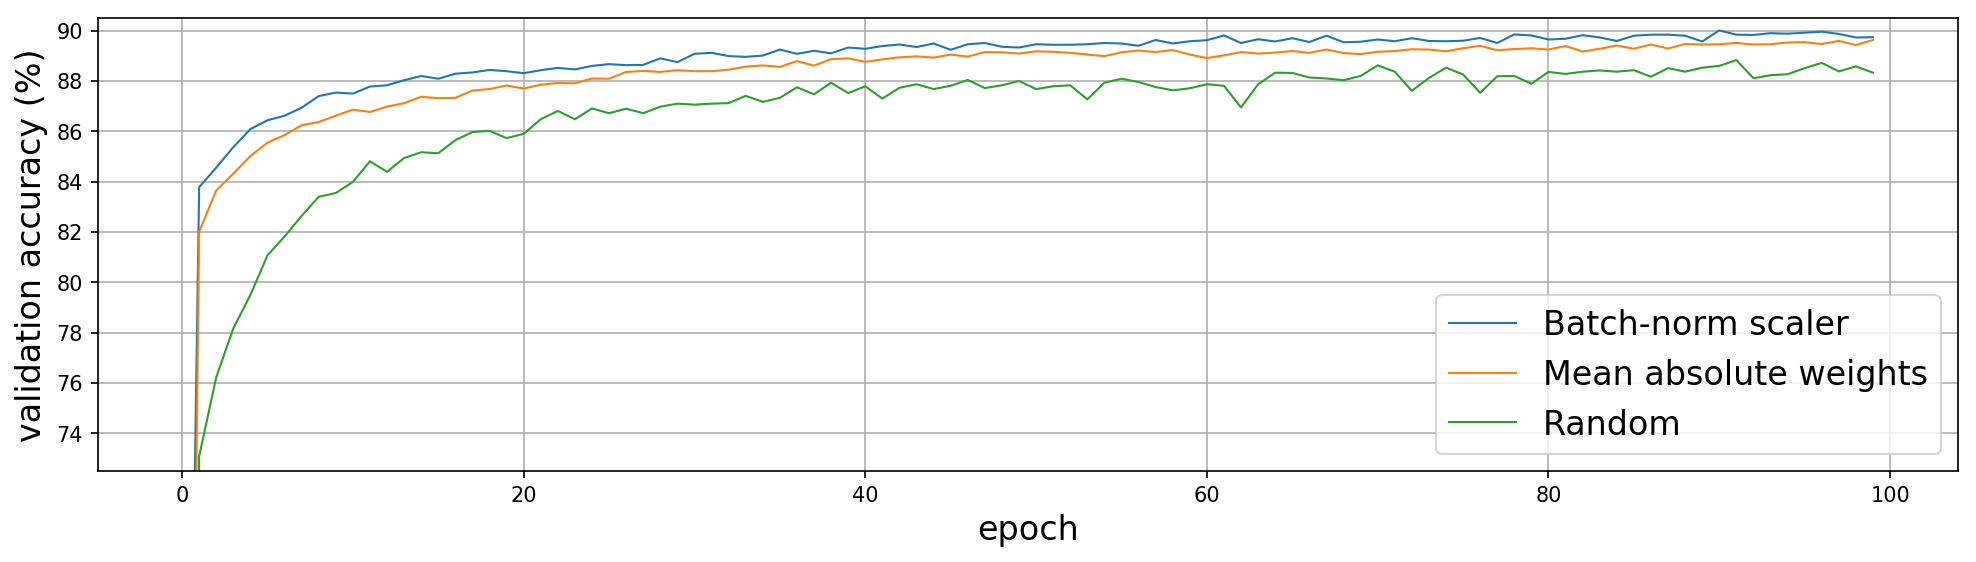

In [15]:
df_bn = pd.read_pickle("./checkpoint/vgg19/results/resDf_1543963251.pkl")
df_mean = pd.read_pickle("./checkpoint/vgg19/results/resDf_1543954107.pkl")
df_rand = pd.read_pickle("./checkpoint/vgg19/results/resDf_1543964135.pkl")

plt.figure(figsize = (16,4), dpi=150)
plt.plot(df_bn.values[0][:100], lw=1)
plt.plot(df_mean.values[0][:100], lw=1)
plt.plot(df_rand.values[0][:100], lw=1)

plt.ylim([72.5, 90.5])
plt.legend(['Batch-norm scaler', 'Mean absolute weights', 'Random'], fontsize=16)

plt.grid(True)
# plt.title("Finetune validation accuracy vs epoch")
plt.xlabel("epoch", fontsize=16)
plt.ylabel("validation accuracy (%)", fontsize=16)
plt.show()